In [51]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

In [141]:
class Point:
    """Holds x and y cordinates"""

    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def get_adjacent(self):
        return [Point(self.x, self.y + 1),
                Point(self.x, self.y - 1),
                Point(self.x + 1, self.y),
                Point(self.x - 1, self.y)]
        
    def get_corners(self):
        gen = itertools.product([1, -1], [1, -1])
        return [Point(self.x + a, self.y + b) for a, b in gen]
            
    def __str__(self):
        return f"({self.x}, {self.y})"

    def __repr__(self):
        return str(self)

    def __eq__(self, other):
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        return hash((self.x, self.y))

    def __gt__(self, other):
        if self == other:
            return True
        elif self.x + self.y > other.x + other.y:
            return True
        else:
            if self.x == other.x:
                return self.y > other.y
            else:
                return self.x > self.y
            
    def __lt__(self, other):
        return self.__gt__(other)
    
def from_string(string):
    return eval("Point" + string)
 
def ident(point):
    return Point(point.x, point.y)

def flip(point):
    return Point(point.x, - point.y)

def rot90(point):
    return Point(point.y, -point.x)

def rot180(point):
    return rot90(rot90(point))

def rot270(point):
    return rot180(rot90(point))

class Orientation():

    def __init__(self, points):
        self.points = tuple(sorted(points))

    def __str__(self):
        return ", ".join([str(p) for p in self.points])

    def __eq__(self, other):
        if len(self.points) != len(other.points):
            return False
        for a, b in zip(self.points, other.points):
            if a != b:
                False
        return True
    
    def get_border_points(self):
        return self.get_related_points("get_adjacent")
    
    def get_corner_points(self):
        border_points = self.get_border_points()
        played_point = {Point(-1, -1)}
        invalid_corners = border_points | played_point 
        return self.get_related_points("get_corners") - invalid_corners
    
    def get_related_points(self, func_name):
        """Generate points related to this orientation."""
        related_points = set()
        for point in self.points:
            relatives = eval(f"point.{func_name}()")
            valid_relatives = set(filter(lambda p: p not in self.points, relatives))
            related_points = related_points | valid_relatives
        return related_points
    
    def is_valid(self):
        invalid_points = [
            Point(0, -1),
            Point(-1, 0),
            Point(-1, -1)
        ]

        for p in self.points:
            if p in invalid_points:
                return False
        return True

    def __hash__(self):
        return hash(self.points)
    
class Piece:

    def __init__(self, points):
        self.orientations = set()
        for transform in self.gen_transforms():
            orientation = Orientation(tuple([transform(point) for point in points]))
            if orientation.is_valid():
                self.orientations.add(orientation)

    def gen_transforms(self):
        flips = [ident, flip]
        rots = [ident, rot90, rot180, rot270]
        for f, r in itertools.product(flips, rots):
            yield lambda x: f(r(x))

    def get_orientation_prime(self):
        for o in self.orientations:
            # will just return the first one
            return o
        
    def __eq__(self, other):
        if len(self.orientations) != len(other.orientations):
            return False
        for o in self.orientations:
            if o not in other.orientations:
                return False
        return True

    def __ne__(self, other):
        return not self == other

    def __str__(self):
        return "\n".join([str(o) for o in self.orientations])
    
# Testing

def test_piece_equals():
    p1 = Piece([Point(0, 0), Point(0, 1)])
    p2 = Piece([Point(0, 1), Point(0, 0)])
    assert(p1 == p2)
    
    p1 = Piece([Point(0, 0), Point(0, 2)])
    p2 = Piece([Point(0, 1), Point(0, 0)])
    assert(p1 != p2)

def test_get_border_points():
    p1 = Piece([Point(0, 0), Point(0, 1)])
    o1 = next(p1.orientations.__iter__())
    
    expected = {Point(a, b) for a, b in [(-1, 1), (0, -1), (-1, 0), (0, 2), (1, 0), (1, 1)]}
    assert(expected == o1.get_border_points())


def test_get_corner_points():
    p1 = Piece([Point(0, 0), Point(0, 1)])
    o1 = next(p1.orientations.__iter__())
    
    expected = {Point(a, b) for a, b in [(1, 2), (-1, 2), (1, -1)]}
    assert{expected == o1.get_corner_points()}

def test_all():
    test_piece_equals()
    test_get_border_points()
    test_get_corner_points()
    
test_all()

## Visualization

In [142]:
class PieceVisualization:
    EMPTY = 0
    FULL = 1
    BORDER = 2
    PLAYABLE = 3
    START = 4
    
    def __init__(self):
        pass
    
    def fill(self, point, value):
        x, y = self.get_indices(point)
        self.matrix[x, y] = value
        
    def get_indices(self, point):
        return point.x + 5, point.y + 5
    
    def display(self, orientation):
        self.init_matrix()
        self.fill_in_points(orientation)
        self.gen_graph()

    def init_matrix(self):
        self.x = [str(x) for x in range(-5, 6)]
        self.y = [str(x) for x in range(-5, 6)]
        matrix = []
        for x in self.x:
            sub = [self.EMPTY for y in self.y]
            matrix.append(sub)
        self.matrix = np.matrix(matrix)

    def fill_in_points(self, orientation):
        for p in orientation.points:
            self.fill(p, self.FULL)

        for p in orientation.get_corner_points():
            self.fill(p, self.PLAYABLE)
        
        for p in orientation.get_border_points():
            self.fill(p, self.BORDER)
            
        self.fill(Point(-1, -1), self.START)

    def gen_graph(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.set_aspect('equal')
        plt.imshow(self.matrix)
        plt.show()
        


## Sandbox

In [ ]:
p1 = Piece([Point(0, 0)])
p2 = Piece([Point(0, 0), Point(0, 1)])
p3 = Piece([Point(0, 0), Point(0, 1), Point(0, 2)])
p4 = Piece([Point(0, 0), Point(0, 1), Point(1, 1)])
p5 = Piece([Point(0, 0), Point(1, 0), Point(0, 1), Point(1, 1)])
p6 = Piece([Point(0, 0), Point(1, 0), Point(2, 0), Point(3, 0)])
p7 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 1)])
p8 = Piece([Point(0, 0), Point(1, 0), Point(1, 1), Point(2, 0)])

#### This doesnt account for all moves

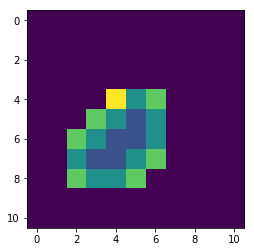

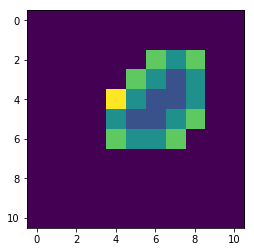

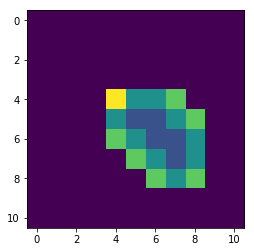

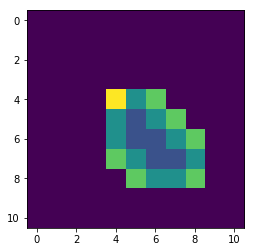

In [144]:
p = Piece([Point(0, 0), Point(0, 1), Point(1, 1), Point(1, 2), Point(2, 2)])
vis = PieceVisualization()
for o in p.orientations:
    vis.display(o)